In [ ]:
%%sh
git clone git@github.com:jcboyd/multi-cell-line.git ../../multi-cell-line
ln -s ../../multi-cell-line/cecog_out_propagate_0.5 ../data/boyd_2019
ln -s ../../multi-cell-line/src

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import *
from src.lococv import construct_profiles, lococv
from src.feature_reader import FeatureReader
from src.vis_utils import image_crop_training_set

data_path = '../data/boyd_2019/'
metadata_file = '../data/boyd_2019_PlateMap-KPP_MOA.xlsx'
df_metadata = pd.read_excel(metadata_file).set_index('well')

# Create drug type column
df_metadata.loc[df_metadata['content'] != 'DMSO', 'category'] = 'Perturbation'
df_metadata.loc[df_metadata['content'] == 'DMSO', 'category'] = 'DMSO'
df_metadata.loc[df_metadata['content'] == 'None', 'category'] = 'None'
df_metadata.loc[df_metadata['content'] == 'Olaparib', 'category'] = 'Positive'
df_metadata.loc[df_metadata['content'] == 'Cisplatine', 'category'] = 'Positive'

# Remove drugs
df_metadata = df_metadata.drop(df_metadata[df_metadata['moa'] == 'Wild'].index)

# Remove wells without content
df_metadata = df_metadata[~df_metadata.content.isnull()]

channels = ['primary__primary4', 'secondary__propagate', 'tertiary__expanded']
plates = {'mda231' : '22_384_20X-hNA_D_F_C3_C5_20160031_2016.01.25.17.23.13_MDA231',
          'mda468' : '22_384_20X-hNA_D_F_C3_C5_20160032_2016.01.25.16.27.22_MDA468'}

plate_data = {}

for cell_line in plates.keys():
    
    ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

    # read handcrafted features
    fr = FeatureReader(plates[cell_line], ch5_path, channels, cell_line)
    fr.read_all()
    fr.data['cell_line'] = cell_line
    plate_data[cell_line] = fr

    problem_feature = 'primary__primary4_dyn_distance_radius_3'
    fr.data = fr.data.drop(problem_feature, axis=1)
    fr.feature_names.remove(problem_feature)

    # Join metadata
    fr.join_plate_map(df_metadata.reset_index())
    fr.data = fr.data[~fr.data['content'].isnull()]

Using TensorFlow backend.
/Users/hclimente/miniconda3/envs/laptop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hclimente/miniconda3/envs/laptop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hclimente/miniconda3/envs/laptop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/User

Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!
Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!


In [2]:
df_mda231 = plate_data['mda231'].data
mda231_wells = set(df_mda231.well)

df_mda468 = plate_data['mda468'].data
mda468_wells = set(df_mda468.well)

common_wells = mda231_wells.intersection(mda468_wells)

df_pooled = pd.concat([df_mda231[df_mda231.well.isin(common_wells)],
                       df_mda468[df_mda468.well.isin(common_wells)]])

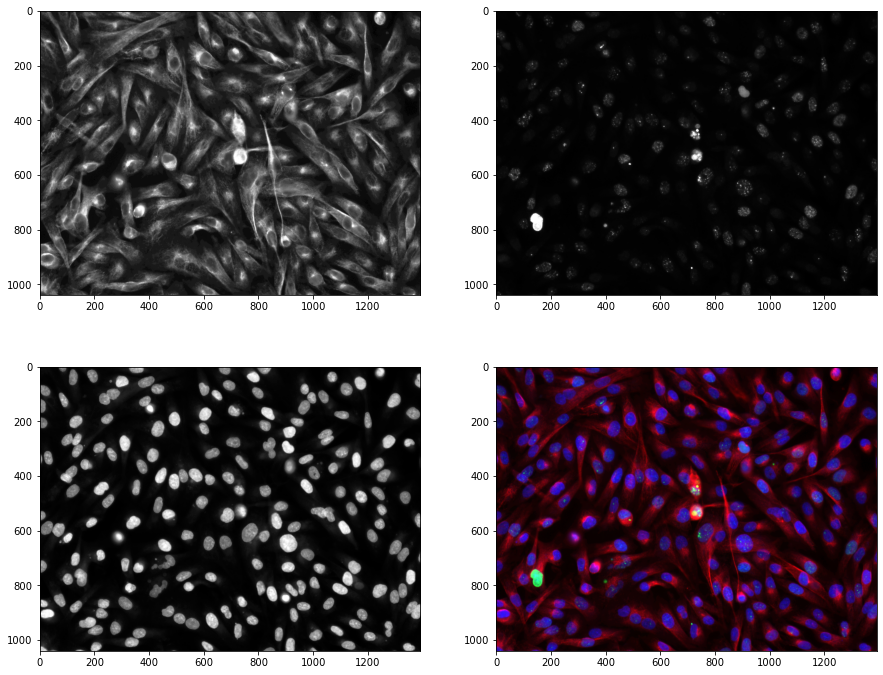

In [3]:
from src.vis_utils import ImageCropper

cell_line = 'mda231'
ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

ic = ImageCropper('A01', 1, ch5_path)
img = ic.get_image()

fig, axes = plt.subplots(figsize=(15, 12), ncols=2, nrows=2)

axes[0][0].imshow(img[..., 0], cmap='Greys_r')
axes[0][1].imshow(img[..., 1], cmap='Greys_r')
axes[1][0].imshow(img[..., 2], cmap='Greys_r')
axes[1][1].imshow(img)

In [4]:
df_mda231 = plate_data['mda231'].data
mda231_wells = set(df_mda231.well)

df_mda468 = plate_data['mda468'].data
mda468_wells = set(df_mda468.well)

common_wells = mda231_wells.intersection(mda468_wells)

df_pooled = pd.concat([df_mda231[df_mda231.well.isin(common_wells)],
                       df_mda468[df_mda468.well.isin(common_wells)]])

# choose dataset_index in range(60)
dataset_index = 43

# read pre-sampled wells from file
df_wells = pd.read_csv('../data/boyd_2019_datasets.csv', index_col=0)
fold_wells = sorted(list(df_wells.loc[dataset_index]))

df_fold = df_pooled[df_pooled.well.isin(fold_wells)].copy()
moas = df_fold.moa.unique()

hc_features = list(filter(lambda x : x.startswith('primary') or
                                     x.startswith('secondary') or
                                     x.startswith('tertiary'), df_pooled.columns))

# normalise cell line data
x_mda231 = df_fold[df_fold.cell_line == 'mda231'][hc_features]
x_mda231 = (x_mda231 - np.mean(x_mda231, axis=0)) / np.std(x_mda231, axis=0)

x_mda468 = df_fold[df_fold.cell_line == 'mda468'][hc_features]
x_mda468 = (x_mda468 - np.mean(x_mda468, axis=0)) / np.std(x_mda468, axis=0)

df_fold[hc_features] = np.vstack([x_mda231, x_mda468])

In [5]:
from src.vis_utils import image_crop_training_set

cell_line = 'mda231'
ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

df = df_fold[df_fold.cell_line == 'mda231']
# df = df_pooled[df_pooled.cell_line == 'mda231']

x_img_mda231 = image_crop_training_set(df, ch5_path, 64, 0.5)

print(x_img_mda231.shape)
print('%.02f Mb' % (sys.getsizeof(x_img_mda231) / float(10 ** 6)))

(11313, 64, 64, 3)
556.06 Mb


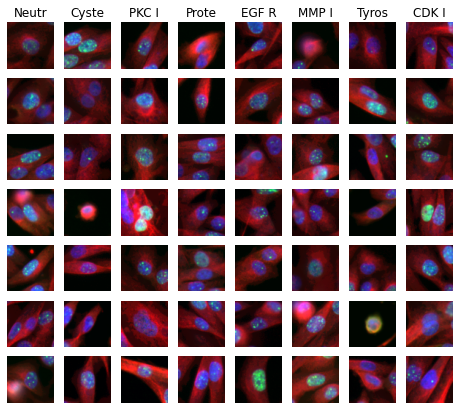

In [6]:
from src.vis_utils import plot_moa_samples

moas = df_fold.moa.unique()
plot_moa_samples(x_img_mda231, df, moas)

In [7]:
cell_line = 'mda468'
ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

df = df_fold[df_fold.cell_line == 'mda468']

x_img_mda468 = image_crop_training_set(df, ch5_path, 64, 0.5)

print(x_img_mda468.shape)
print('%.02f Mb' % (sys.getsizeof(x_img_mda468) / float(10 ** 6)))

(7549, 64, 64, 3)
371.05 Mb


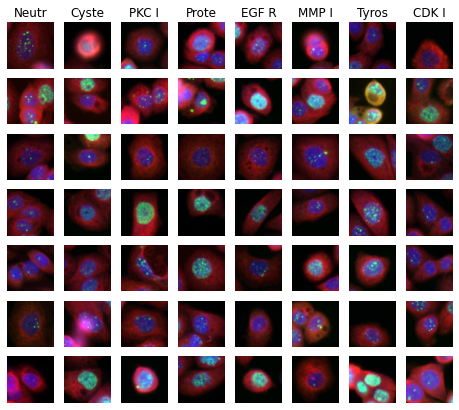

In [8]:
plot_moa_samples(x_img_mda468, df, moas)

# Data generator

In [9]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

class SiameseNetworkDataset(Dataset):
    
    def __init__(self, dataset_1, labels_1, dataset_2, labels_2):
        self.dataset_1 = dataset_1
        self.labels_1 = labels_1
        self.dataset_2 = dataset_2
        self.labels_2 = labels_2
        
        self.moas = list(set(labels_1) and set(labels_2))
        
    def __getitem__(self,index):
        img0_i = random.randrange(len(self.dataset_1))
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_i = random.randrange(len(self.dataset_2))
                if self.labels_1[img0_i]==self.labels_2[img1_i]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                img1_i = random.randrange(len(self.dataset_2))
                if self.labels_1[img0_i]!=self.labels_2[img1_i]:
                    break


        img0 = self.dataset_1[img0_i]
        img1 = self.dataset_2[img0_i]
                
        return img0, img1, torch.from_numpy(np.array([int(self.labels_1[img0_i]!=self.labels_2[img1_i])],dtype=np.float32))
    
    def __len__(self):
        return len(self.dataset_1) + len(self.dataset_2)

In [10]:
x_img_mda468 = np.moveaxis(x_img_mda468, 3, 1)
x_img_mda231 = np.moveaxis(x_img_mda231, 3, 1)

siamese_dataset = SiameseNetworkDataset(x_img_mda468, list(df_fold.loc[df_fold.cell_line == 'mda468', 'moa']),
                                        x_img_mda231, list(df_fold.loc[df_fold.cell_line == 'mda231', 'moa']))

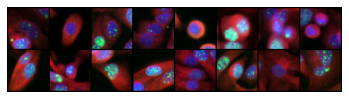

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [11]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# NN

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(32768, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [13]:
class Config():
    training_dir = "./data/boyd_2019/training/"
    testing_dir = "./data/boyd_2019/testing/"
    train_batch_size = 64
    train_number_epochs = 100

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [14]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)